# Analysis of GSE21784

Tong Shu Li

Does this dataset drift?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
sys.path.append("..")

In [3]:
from src.plots import plot_multi_density

In [4]:
%matplotlib inline

---

## Read expression values

In [5]:
exp = pd.read_csv("../data/GSE21784/annot_GSE21784.tsv", sep = '\t')

In [6]:
exp.shape

(198279, 8)

In [7]:
exp.head()

,probe_id,geo_id,log2_exp,age,days_old,replicate,entrez_id,wormbase_id
0,171720_x_at,GSM542652,8.71,L4 larvae,0,1,174997,WBGene00013011
1,171720_x_at,GSM542653,8.49,L4 larvae,0,2,174997,WBGene00013011
2,171720_x_at,GSM542654,8.80,L4 larvae,0,3,174997,WBGene00013011
3,171720_x_at,GSM542655,8.63,day 6 adults,6,1,174997,WBGene00013011
4,171720_x_at,GSM542656,9.01,day 6 adults,6,2,174997,WBGene00013011


In [8]:
exp["probe_id"].nunique()

22031

## Distribution of CPM

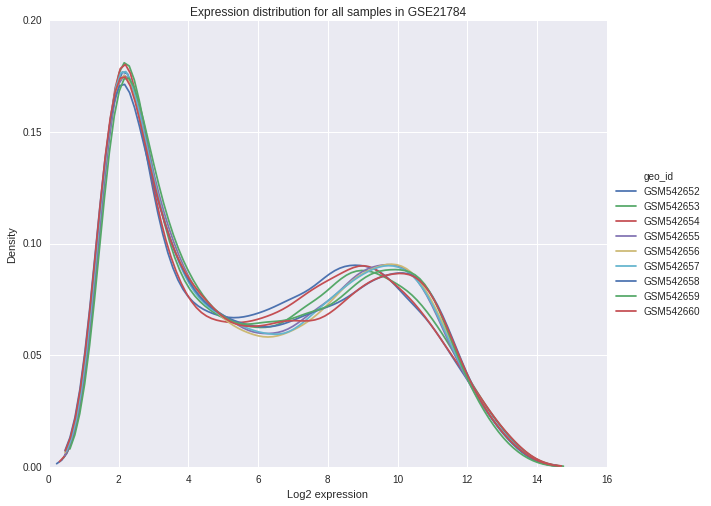

In [9]:
ax = plot_multi_density(
    exp, "geo_id", "log2_exp",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Expression distribution for all samples in GSE21784")
ax.set_xlabel("Log2 expression");

These expression profiles look relatively similar. We may want to do some filtering to remove genes which have very low expression, but at the moment I will keep all genes.

## Calculate young reference

We will average the three replicates of the L4 worms to create a young reference expression profile.

In [10]:
ref = (
    exp.query("days_old == 0")
        [["probe_id", "log2_exp"]]
        .groupby("probe_id", as_index = False)
        .mean()
        .rename(columns = {"log2_exp": "ref_log2_exp"})
)

In [11]:
ref.shape

(22031, 2)

In [12]:
ref.head()

,probe_id,ref_log2_exp
0,171720_x_at,8.666667
1,171721_x_at,9.913333
2,171722_x_at,11.196667
3,171723_x_at,12.920000
4,171724_x_at,9.213333


## Calculate relative log fold expression change

In [13]:
data = (
    pd.merge(exp, ref, how = "inner", on = "probe_id")
        .assign(RLFEC = lambda df: df["log2_exp"] - df["ref_log2_exp"])
)

In [14]:
data.shape

(198279, 10)

In [15]:
data.head()

,probe_id,geo_id,log2_exp,age,days_old,replicate,entrez_id,wormbase_id,ref_log2_exp,RLFEC
0,171720_x_at,GSM542652,8.71,L4 larvae,0,1,174997,WBGene00013011,8.666667,0.043333
1,171720_x_at,GSM542653,8.49,L4 larvae,0,2,174997,WBGene00013011,8.666667,-0.176667
2,171720_x_at,GSM542654,8.80,L4 larvae,0,3,174997,WBGene00013011,8.666667,0.133333
3,171720_x_at,GSM542655,8.63,day 6 adults,6,1,174997,WBGene00013011,8.666667,-0.036667
4,171720_x_at,GSM542656,9.01,day 6 adults,6,2,174997,WBGene00013011,8.666667,0.343333


## Plot RLFEC

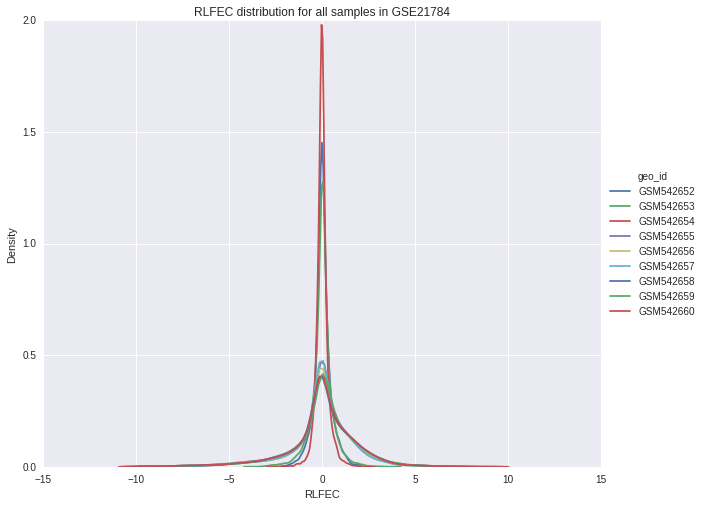

In [16]:
ax = plot_multi_density(
    data, "geo_id", "RLFEC",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("RLFEC distribution for all samples in GSE21784")
ax.set_xlabel("RLFEC");

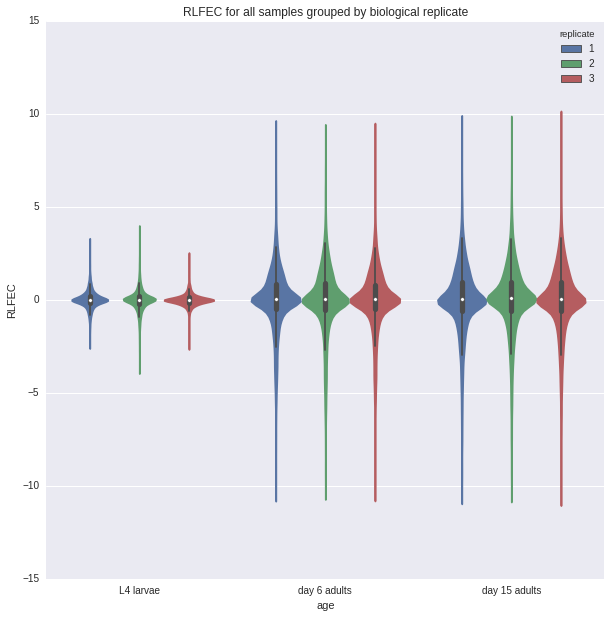

In [17]:
fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.violinplot(
    data = data, y = "RLFEC", x = "age", hue = "replicate",
    ax = ax
)

ax.set_title("RLFEC for all samples grouped by biological replicate");

Seems like the drift is very high in these samples. Notice how the young samples are very tightly clustered together, but the others are much more flattened out.

## Calculate drift

In [18]:
drift = (
    data[["days_old", "replicate", "geo_id", "age", "RLFEC"]]
        .groupby(["days_old", "replicate", "geo_id", "age"], as_index = False)
        .var()
        .rename(columns = {"RLFEC": "drift"})
)

In [19]:
drift

,days_old,replicate,geo_id,age,drift
0,0,1,GSM542652,L4 larvae,0.232924
1,0,2,GSM542653,L4 larvae,0.374660
2,0,3,GSM542654,L4 larvae,0.119568
3,6,1,GSM542655,day 6 adults,3.366580
4,6,2,GSM542656,day 6 adults,3.722587
5,6,3,GSM542657,day 6 adults,3.393726
6,15,1,GSM542658,day 15 adults,4.034411
7,15,2,GSM542659,day 15 adults,3.985216
8,15,3,GSM542660,day 15 adults,4.026318


## Plot drift

### Linear model

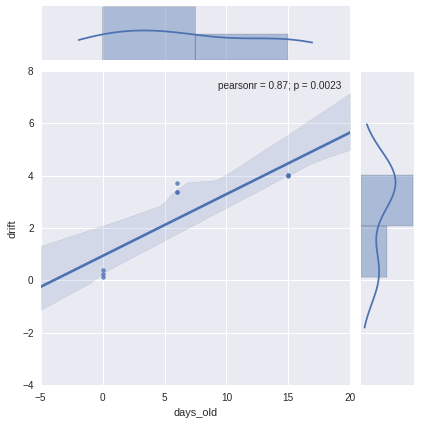

In [20]:
sns.jointplot(
    data = drift, x = "days_old", y = "drift",
    kind = "reg"
);

#### Residuals

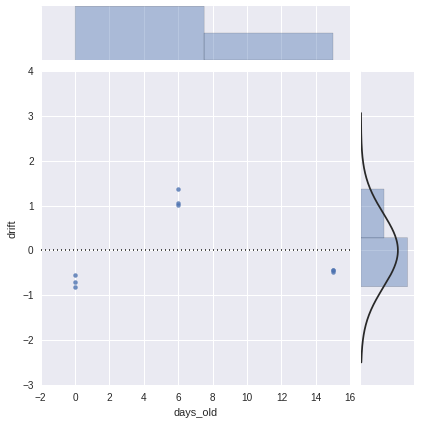

In [21]:
sns.jointplot(
    data = drift, x = "days_old", y = "drift",
    kind = "resid"
);

There is a definite increasing trend of drift in this dataset, but again it seems like the best fit may not be linear.

### Loglinear model

Since we can't take the log of zero, we will alter the data slightly to say that L4 worms are the same as 1 day old (this is not true, but we are simplifying this specifically to see if a loglinear regression would fit).

In [22]:
drift["log_day"] = np.log(drift["days_old"] + (drift["days_old"] == 0))

In [23]:
drift

,days_old,replicate,geo_id,age,drift,log_day
0,0,1,GSM542652,L4 larvae,0.232924,0.000000
1,0,2,GSM542653,L4 larvae,0.374660,0.000000
2,0,3,GSM542654,L4 larvae,0.119568,0.000000
3,6,1,GSM542655,day 6 adults,3.366580,1.791759
4,6,2,GSM542656,day 6 adults,3.722587,1.791759
5,6,3,GSM542657,day 6 adults,3.393726,1.791759
6,15,1,GSM542658,day 15 adults,4.034411,2.708050
7,15,2,GSM542659,day 15 adults,3.985216,2.708050
8,15,3,GSM542660,day 15 adults,4.026318,2.708050


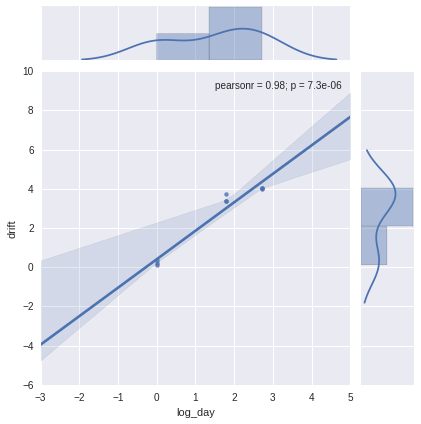

In [24]:
sns.jointplot(
    data = drift, x = "log_day", y = "drift",
    kind = "reg"
);

#### Residuals

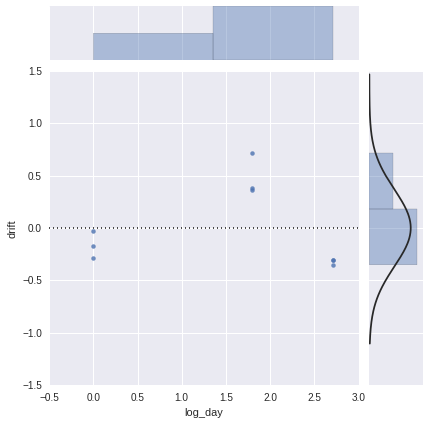

In [25]:
sns.jointplot(
    data = drift, x = "log_day", y = "drift",
    kind = "resid"
);

The residuals are perhaps better distributed about zero, but really it's difficult to say since we have so few data points. The R value does seem to be higher with the loglinear model, but again there are very few data points.

## Conclusion

This dataset is promising in terms of increasing drift, but interpretation is difficult because the worm life status changes halfway through (L4 to adult). Overall there does seem to be change, but again more data are necessary to draw robust conclusions.